# Machine learning - Assignment 5 - The bootstrap method
____
**Author**: Kemal Cikota

**Course**: Machine learning
____

## Introduction

In this assignment, i will explore the use of **bootstrap methods** for estimating the accuracy of regression model parameters. The difference between bootstrapping methods and regular statistical methods for estimating performance metrics is that bootstrap does not rely on strict assumptions on the distribution of the data. This report will include a conceptual/theoreticall part, which includes a discussion about k-fold cross validation and one practical part i apply bootstrapping methods to estimate standard errors for linear and quadratic regression models.

I am a complete nerd when it comes to cars so this dataset was quite intuitive and easy for me to understand but for those that dont know, [this source](https://islp.readthedocs.io/en/latest/datasets/Auto.html) can be used as a reference for what the features mean. Theese short descriptions can be of great help.

## Conceptual Questions

**1. explain how k-fold cross-validation is implemented**
K-fold cross-validation is a resampling technique used to evaluate the performance of a model while making efficient use of avaliable data, here is how it may be implemented.

- <ins>Divide data</ins>: The data should first be divided in to k equal parts. Theese k amount of parts are also called the "folds", hence the name, "K-fold".
- <ins>Train and validate (iteratively)</ins>: For each iteration, one of the folds is used as the validation set, while the other remaining folds are combined to form the training set. The model will be trained with theese combined training folds and evaluated on the validation fold. This process will repeat K-amounts of times, with each fold servind as the validation set just once.
- <ins>Compute performance metrics</ins>: After theese K-amounts of iterations, the performance metrics (such as $R^2$ or MSE) from each iteration are averaged to provide an overall estimate.

The amounts of K we have in practice can varry a lot depending on the data and circumstances we are dealing with but it is often common to use something like K=5 or K=10 but higher K's like 15 can also be used. There is also a special case of K-fold called "Leave One Out Cross Validation" (LOOCV) where k=N where N is the total number of data points. This is often used when the dataset is relatively small because LOOCV makes sure that every possible training sample is used, which maximizes the amount of data for training the model.

In general though, K-fold is useful because its ability to "average out" the performance metrics so it helps reduce overfitting compared to just single train/test split metric measuerment. 

**2. What are advantages and disadvantages of k-fold crossvalidation relative to the validation set approach?**
So i have already discusssed what K-fold is and what it roughly does in the previous conceptual task, the validation set approach is just a simple train/test split where we have a random seed that randomly splits the data in to one training and one validation set with just one iteration.

The advantages of using K-fold over the standard validation set approaches are:
- Instead of using a fixed portion of the data for validation, each datapoint gets a chance to be in the validation set if we use K-folds, this ensures that the model is trained on more data and in different orders which leads to better generalization if we were to have some arbitrary new data.
- Because K-fold has an ability to "average out" or "flatten" the performance measurements, the end value we get for some metric (for example $R^2$) is more stable and reliable because it is the final average value of multiple iteration which reduces variances compared to validation setting. This is important because the validation set approach can sometimes make a model look much better then it actually is because the split is "lucky" where the validation set contains easy examples. This can also work the other way around for "unlucky" splits so thats why its good to have an average.
- Training the model of different subsets of data reduces the likelihood that a model will be overfitted to a particular training set because it is trained on more variety of data.

The disadvantages of using K-fold over the standard validation set approaches are:
- doing K-fold requires K times more computation than a single validation set approach. So if we have K=10 or even higher, then that means that K-fold would use 10 times or more data to train the model than if we were just to have a constant split and train once. So for complex datasets that includes a lot of features that are complex, this can be very impractical.
- Sometimes, it can be hard to find the best K to use for some dataset. And it is in general harder to implement  K-fold than a normal validation set approach as it requires us to partition the data well and loop over it in multiple iterations.

**3. What are advantages and disadvantages of k-fold crossvalidation relative LOOCV?**

The advantages of using K-fold over LOOCV are:
- Because, in LOOCV we use K=N where N is the amount of datapoints in our data, it can be very computationally heavy for larger datasets as for regular K-fold we use something like K=5 or K=10 usually. This makes LOOCV less reasonable to use for larger datasets because it can require several times more data than even K=10.
- Because LOOCV uses all of the datapoints as folds for the iteration, it can sometimes lead to overfitting since the training set in each iteration is almost the entire dataset while K-fold has more diversity in the training subsets for each iteration.
- K-fold gives a much smoother estimate by averaging over multiple folds with more varied training sets as compared to LOOCV that produces performance values that have high variance because each validation set only consists of one single data point.

The disadvantages of using K-fold over LOOCV are:
- Even though K-fold has less variance between the iterations as compared to LOOCV, K-fold will have a higher bias in the performance estimates because the LOOCV uses almost all the data for training which makes the model very similar to the one trained on the full dataset.
- because in K-fold we choose K ourselves, it meaans that we have some room for error in the evaluation since the outcome is dependent on K which is our choice. This makes the LOOCV method somewhat deterministic since the uses every single data point excactly once. 

## Practical

For the practical part of the assignment, i have to work with the auto.csv dataset which consists of some information about cars like the name and year but we also have some stats about each car like weight, horsepower, miles per galon (MPG) and engine displacement. With this data i will use bootstraping methods to estimate the standard errors of parameters of a linear regression and quadratic regression models predictive ability.

### Load the data and get an overview of the data


In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np

from sklearn.utils import resample

# load auto.csv
auto = pd.read_csv('Auto.csv')

# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

Once the dataset is loaded, we can display the number of predictors (variables/columns) and their names.

In [38]:
numFeatures = auto.shape[1]
print(numFeatures)

featureNames = auto.columns.tolist()
print(featureNames, end="\n\n")

10
['Unnamed: 0', 'mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']



We can now also print a statistic summary of the predictors and responses.

In [39]:
print(auto.describe(), end="\n\n")

       Unnamed: 0         mpg   cylinders  displacement  horsepower  \
count  392.000000  392.000000  392.000000    392.000000  392.000000   
mean   198.520408   23.445918    5.471939    194.411990  104.469388   
std    114.438067    7.805007    1.705783    104.644004   38.491160   
min      1.000000    9.000000    3.000000     68.000000   46.000000   
25%     99.750000   17.000000    4.000000    105.000000   75.000000   
50%    198.500000   22.750000    4.000000    151.000000   93.500000   
75%    296.250000   29.000000    8.000000    275.750000  126.000000   
max    397.000000   46.600000    8.000000    455.000000  230.000000   

            weight  acceleration        year      origin  
count   392.000000    392.000000  392.000000  392.000000  
mean   2977.584184     15.541327   75.979592    1.576531  
std     849.402560      2.758864    3.683737    0.805518  
min    1613.000000      8.000000   70.000000    1.000000  
25%    2225.250000     13.775000   73.000000    1.000000  
50%   

We can now also display the total number of datapoints

In [40]:
print("total amount of datapoints: ", auto.shape[0], end="\n\n")

total amount of datapoints:  392



We can now also display the entire dataset.

In [41]:
auto

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,1,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,2,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,3,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,4,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,5,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...,...
387,393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


We can now compute the pairwise correlation of the predictors in the dataset. We can do this by plotting the correlation matrix between the pairwise features. In the example, i can see that the 'name' feature was dropped so i did the same in my demonstration.

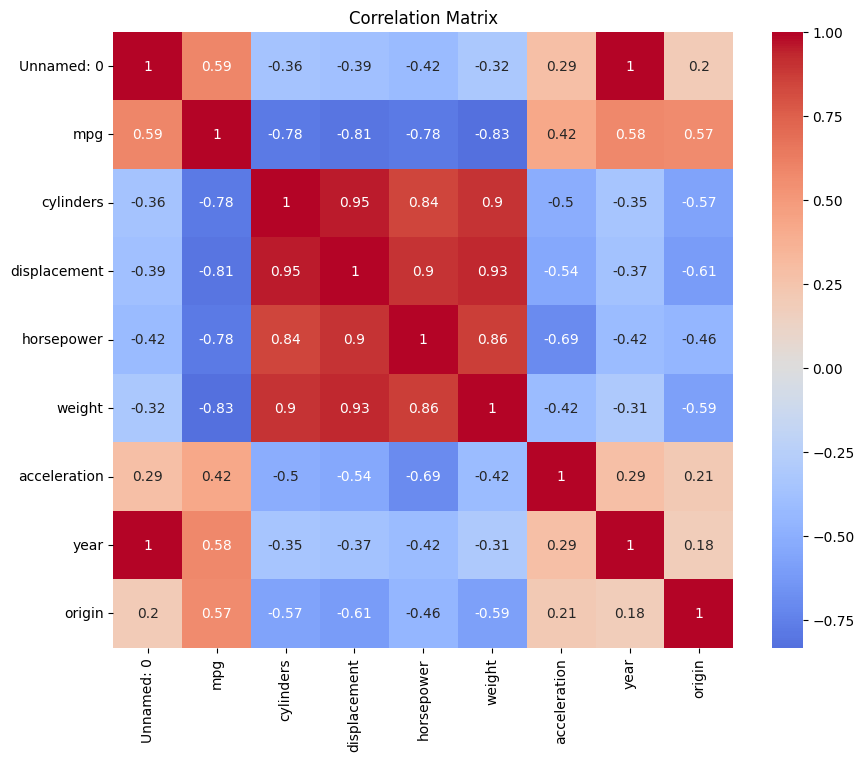

In [42]:
# drop direction column
auto = auto.drop(columns=['name'])

correlation_matrix = auto.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

In [43]:
auto = pd.read_csv('Auto.csv')
auto['horsepower'] = pd.to_numeric(auto['horsepower'], errors='coerce')
auto = auto.dropna()


def boot_fn(data, indices):

    sample = data.iloc[indices]
    X = sample["horsepower"]
    y = sample["mpg"]

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    return model.params

indicies = np.arange(len(auto))
print("Auto dataset regression coefficients: \n\n", boot_fn(auto, indicies))

Auto dataset regression coefficients: 

 const         39.935861
horsepower    -0.157845
dtype: float64


In [44]:
np.random.seed(1)

bootstrap_indicies = np.random.choice(indicies, len(auto), replace=True)
print("Bootstrap 1 regression coefficients: \n\n", boot_fn(auto, bootstrap_indicies))

Bootstrap 1 regression coefficients: 

 const         39.658479
horsepower    -0.155898
dtype: float64


In [45]:
bootstrap_indicies = np.random.choice(indicies, len(auto), replace=True)
print("Bootstrap 2 regression coefficients: \n\n", boot_fn(auto, bootstrap_indicies))

Bootstrap 2 regression coefficients: 

 const         40.733271
horsepower    -0.163901
dtype: float64


In [46]:
X = auto["horsepower"]
y = auto["mpg"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

original_coefs = model.params
model_se = model.bse

print("\nOriginal Coefficients: ")
print(original_coefs)

def bootstrap_lr(X, y, n_bootstrap=1000):
    coef_samples = []
    
    for i in range(n_bootstrap):
        X_resampled, y_resampled = resample(X, y, replace=True)
        model_resampled = sm.OLS(y_resampled, X_resampled).fit()
        coef_samples.append(model_resampled.params)

    coef_samples = np.array(coef_samples)
    
    bootstrap_means = np.mean(coef_samples, axis=0)
    se_bootstrap = np.std(coef_samples, axis=0)
    bias = bootstrap_means - original_coefs

    return bootstrap_means, bias, se_bootstrap

X = auto["horsepower"]
y = auto["mpg"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

bootstrap_means, bias, se_bootstrap = bootstrap_lr(X, y)

# Print Bootstrap Statistics similar to the image
print("\nBootstrap Statistics:")
print(f"{'':<10}{'Original':>15}{'Bias':>15}{'Std. Error':>15}")
for i, coef_name in enumerate(["Intercept", "Horsepower"]):
    print(f"{coef_name:<10}{bootstrap_means[i]:>15.6f}{bias[i]:>15.6f}{se_bootstrap[i]:>15.6f}")


Original Coefficients: 
const         39.935861
horsepower    -0.157845
dtype: float64

Bootstrap Statistics:
                 Original           Bias     Std. Error
Intercept       39.963973       0.028112       0.825412
Horsepower      -0.158307      -0.000462       0.007135


C:\Users\kemal\AppData\Local\Temp\ipykernel_38896\840415305.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{coef_name:<10}{bootstrap_means[i]:>15.6f}{bias[i]:>15.6f}{se_bootstrap[i]:>15.6f}")


In [47]:
model.summary()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Mon, 03 Mar 2025   Prob (F-statistic):           7.03e-81
Time:                        09:06:04   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

From the correlation matrix we can see that we got strong negative correlation between mpg and horsepower, weight and displacement. This makes sence as the weight of the car increases it perhaps needs a stronger engine and this engine will perhaps consume more fuel on average. This is why we used mpg as a response variable to horsepower.

We can also see that the variables cylinders, displacement and horsepower are highly positively correlated with each other. 

We can then see that when we apply the regular least squares OLS regression on the full dataset, i can use the model.params function in order to return the intercept and slope from the 392 observations and we got the following:
- Intercept $(\beta_0) = 39.94$
- slope $(\beta_1) = -0.1578$

This means that when horsepower is 0, the expected mpg would be 39.94. And also each additional unit of horsepower would decrease mpg by 0.1578 units on average, which confirms the negative relationship in the correlation analysis.

In order to validate this result that we got from OLS, i used bootstrapping to generate alternative regression estimates. I did this by randomly sampling data and computing new estimates for $\beta_0$ and $\beta_1$ and then running the process multiple times to get an empirical distribution of coefficients. From that we got a slight variation of the original OLS estimates, which shows that our model is stable.

We could also see from the standard errors that the bootstrapping standard errors were slightly larger which menas that bootstrapping takes sample variability in to account which OLS built-in probably does not.


### Estimating the accurcay of a quadratic regression model

In [48]:
X = auto["horsepower"]
y = auto["mpg"]

X_quad = pd.DataFrame({
    "const": 1,                # intercept
    "horsepower": X,
    "horsepower^2": X**2
})

model_quad = sm.OLS(y, X_quad).fit()
original_coefs_quad = model_quad.params

print("\nOriginal Quadratic Coefficients:")
print(original_coefs_quad)

def bootstrap_lr_quadratic(X_quad, y, n_bootstrap=1000):
    coef_samples = []
    
    for i in range(n_bootstrap):
        data_resampled = resample(pd.concat([X_quad, y], axis=1), replace=True)

        X_resampled = data_resampled[X_quad.columns]
        y_resampled = data_resampled[y.name]

        model_resampled = sm.OLS(y_resampled, X_resampled).fit()
        coef_samples.append(model_resampled.params)
    
    coef_samples = np.array(coef_samples)
    
    bootstrap_means = coef_samples.mean(axis=0)
    se_bootstrap = coef_samples.std(axis=0)
    bias = bootstrap_means - original_coefs_quad
    
    return bootstrap_means, bias, se_bootstrap

bootstrap_means_quad, bias_quad, se_bootstrap_quad = bootstrap_lr_quadratic(X_quad, y)

print("\nBootstrap Statistics:")
print(f"{'':<10}{'Original':>15}{'Bias':>15}{'Std. Error':>15}")
for i, coef_name in enumerate(["Intercept", "Horsepower", "Horsepower^2"]):
    print(f"{coef_name:<10}{bootstrap_means_quad[i]:>15.6f}{bias_quad[i]:>15.6f}{se_bootstrap_quad[i]:>15.6f}")



Original Quadratic Coefficients:
const           56.900100
horsepower      -0.466190
horsepower^2     0.001231
dtype: float64

Bootstrap Statistics:
                 Original           Bias     Std. Error
Intercept       57.040104       0.140005       2.094747
Horsepower      -0.468068      -0.001878       0.033261
Horsepower^2       0.001237       0.000006       0.000120


C:\Users\kemal\AppData\Local\Temp\ipykernel_38896\3277305726.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{coef_name:<10}{bootstrap_means_quad[i]:>15.6f}{bias_quad[i]:>15.6f}{se_bootstrap_quad[i]:>15.6f}")


In [49]:
# include horsepower^2 in the model
X_quad = pd.DataFrame({
    "const": 1,                # intercept
    "horsepower": X,
    "horsepower^2": X**2
})

model_quad = sm.OLS(y, X_quad).fit()

model_quad.summary()
print(model_quad.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Mon, 03 Mar 2025   Prob (F-statistic):           5.40e-99
Time:                        09:06:07   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           56.9001      1.800     31.604   

After fitting a simple and basic linear regression model to predict mpg based on horsepower, we now extend our analysis by incorporating a quadratic term "Horsepower^2" which will allow us to capture non-linear relationships between our variables.

Keep in mind that the new model will now look something like this mathematically:

$$mpg = \beta_0 + \beta_1 * (horsepower) + \beta_2 * (Horsepower^2) + \epsilon$$

As last time, we used the OLS summary and params functions to estimate the coefficients and get further information about the modified model.

We can see that horsepower and horsepower^2 are highly significant as their P-values are very low, this confirms for us that the newly added term is useful and makes a meaningful contribution to the end-result of the model. We still have a negative coefficient for horsepower (-0.466) but positive for horsepower^2 which means that there is a curved relationship. The model $R^2$ is 0.688 which was higher than the linear model.

Now we can give a full summary that compares the bootstrapping resampling method to OLS when estimating standard errors, biases and means of our coefficients in a table. A nice addition to this is that i also included the biases which is the difference between the OLS and bootstrap means. I also rounded the numbers from my outputs in order to make the table more compact and easier to read.

### Summary


| coefficient          | OLS mean | bootstrap mean | bias    | OLS std error | bootstrap std. error |
|----------------------|----------|----------------|---------|---------------|----------------------|
| intercept $\beta_0$  | 56.9     | 56.78          | -0.116  | 1.8           | 2.11                 |
| Horsepower $\beta_1$ | -0.466   | -0.464         | 0.002   | 0.031         | 0.033                |
| Horsepower $\beta_2$ | 0.0012   | 0.0012         | 0.00006 | 0.0001        | 0.00012              |

- The bootstrap standard error is slightly larger than the OLS, particularly for the intercept.
- Biases are very small which means that OLS is pretty unbiased
- Including quadratic term improves the model because we confirm from the coefficients that the relationship between mpg and horsepower is not strictly linear.
- Since the results of the bootstrapping closely match the OLS results, **we validate the reliability of the OLS model.**